In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks')

ModuleNotFoundError: No module named 'google.colab'

# New section

In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import seaborn as sns
import tensorflow as tf
from TrajectoryObject import TrajectoryObj
from FileIO import write_trajectory, read_trajectory, read_mosaic, read_localization, read_andi2_trajectory_label
from andi_datasets.models_phenom import models_phenom
from andi_datasets.datasets_phenom import datasets_phenom
from andi_datasets.utils_trajectories import plot_trajs
from andi_datasets.utils_challenge import label_continuous_to_list
from stochastic import random as strandom

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2024-03-29 16:02:53.133270: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-29 16:02:53.605408: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/junwoo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
NB_INPUT_FEATURES = 4
NB_LABEL_FEATURES = 5
WINDOW_WIDTH=32
SHUFFLE=True
MAX_EPOCHS = 10000
BATCH_SIZE=256
PATIENCE=250

In [3]:
#random.seed(38)
#strandom.seed(38)

In [4]:
N = 2
K_bound = [1e-12, 1000000.0]
alpha_bound = [0, 1.999]
cp_seqs = []
non_cp_seqs = []

In [6]:
while len(cp_seqs) < 10000:
    Ts = [32, 64, 128, 200]
    alphas = [0.001, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 1.999]
    T = int(np.random.choice(Ts, 1, replace=False)[0])
    alpha1, alpha2 = np.random.choice(alphas, 2, replace=False)
    trajs_model, labels_model = models_phenom().multi_state(N=N,
                                                            L=None,
                                                            T=T,
                                                            alphas=[alpha1, alpha2],  # Fixed alpha for each state
                                                            Ds=[[0.1, 0.0], [0.1, 0.0]],# Mean and variance of each state
                                                            M=[[0.98, 0.02], [0.02, 0.98]]
                                                           )
    changepoints, alphas, Ds, state_num = label_continuous_to_list(labels_model[:, 0, :])
    for cp in changepoints:
        if int(WINDOW_WIDTH/2) < cp < len(trajs_model[:, 0, :]) - int(WINDOW_WIDTH/2):
            change_point_containing_seq = trajs_model[:, 0, :][cp - int(WINDOW_WIDTH/2) : cp + int(WINDOW_WIDTH/2)]
            for _ in range(100000):
                flag = 1
                non_cp = np.random.randint(0 + int(WINDOW_WIDTH/2), T - int(WINDOW_WIDTH/2))
                non_cp_range = np.arange(non_cp - int(WINDOW_WIDTH/2), non_cp + int(WINDOW_WIDTH/2))
                for all_cps in changepoints:
                    if all_cps not in non_cp_range:
                        flag *= 1
                    else:
                        flag *= 0
                if flag == 1:
                    non_change_point_containing_seq = trajs_model[:, 0, :][non_cp - int(WINDOW_WIDTH/2) : non_cp + int(WINDOW_WIDTH/2)]

                    for index, seqxy in enumerate([[change_point_containing_seq[:, 0], change_point_containing_seq[:, 1]],
                                  [non_change_point_containing_seq[:, 0], non_change_point_containing_seq[:, 1]]]):
                        xs = seqxy[0]
                        ys = seqxy[1]
                        xs = (xs - np.mean(xs)) / np.std(xs)
                        ys = (ys - np.mean(ys)) / np.std(ys)
                        if xs[0] > 0:
                            xs = -xs
                        if ys[0] > 0:
                            ys = -ys
                    
                        freq_x = np.fft.fftfreq(xs.shape[-1])
                        sp_x_real = abs(np.fft.fft(xs).real)
                        sp_x_imag = abs(np.fft.fft(xs).imag)
                    
                        freq_y = np.fft.fftfreq(ys.shape[-1])
                        sp_y_real = abs(np.fft.fft(ys).real)
                        sp_y_imag = abs(np.fft.fft(ys).imag)   
                    
                        concat_arr_x = np.array([xs, freq_x, sp_x_real, sp_x_imag]).T
                        concat_arr_y = np.array([ys, freq_y, sp_y_real, sp_y_imag]).T

                        if index == 0:
                            cp_seqs.append(concat_arr_x)
                            cp_seqs.append(concat_arr_y)
                        else:
                            non_cp_seqs.append(concat_arr_x)
                            non_cp_seqs.append(concat_arr_y)
                    break
    if len(cp_seqs)%100 == 0: print(len(cp_seqs))

0
0
100
600
600
900
1000
1100
1200
1700
1700
1700
1800
2000
2000
2000
2000
2100
2800
2800
2800
3100
3100
3300
3300
3400
3600
4100
4200
4500
4600
4800
4800
4800
5300
5400
5400
6200
6600
6700
6800
6800
6900
6900
6900
6900
7300
7300
8200
8600
8800
8900
9600
9600
9600
9700
9800
10000


In [7]:
cp_seqs = np.array(cp_seqs)
non_cp_seqs = np.array(non_cp_seqs)
print(cp_seqs.shape, non_cp_seqs.shape)
train_data = np.vstack((cp_seqs[:int(0.7 * len(cp_seqs))], non_cp_seqs[:int(0.7 * len(non_cp_seqs))]))
train_label = np.vstack((np.ones((cp_seqs.shape[0], 1))[:int(0.7 * len(cp_seqs))], np.zeros((non_cp_seqs.shape[0], 1))[:int(0.7 * len(non_cp_seqs))]))

val_data = np.vstack((cp_seqs[int(0.7 * len(cp_seqs)):], non_cp_seqs[int(0.7 * len(non_cp_seqs)):]))
val_label = np.vstack((np.ones((cp_seqs.shape[0], 1))[int(0.7 * len(cp_seqs)):], np.zeros((non_cp_seqs.shape[0], 1))[int(0.7 * len(non_cp_seqs)):]))


print(train_data.shape, train_label.shape)
print(val_data.shape, val_label.shape)

train_shuffle_index = np.arange(train_data.shape[0])
val_shuffle_index = np.arange(val_data.shape[0])
np.random.shuffle(train_shuffle_index)
np.random.shuffle(val_shuffle_index)
train_data = train_data[train_shuffle_index]
train_label = train_label[train_shuffle_index]
val_data = val_data[val_shuffle_index]
val_label = val_label[val_shuffle_index]


(10000, 32, 4) (10000, 32, 4)
(14000, 32, 4) (14000, 1)
(6000, 32, 4) (6000, 1)


In [8]:
train_tf = tf.data.Dataset.from_tensor_slices((train_data, train_label)).batch(BATCH_SIZE)
val_tf = tf.data.Dataset.from_tensor_slices((val_data, val_label)).batch(BATCH_SIZE)
print(train_tf)
print(val_tf)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 32, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 32, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>


2024-03-29 16:10:31.242339: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-29 16:10:31.247161: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-29 16:10:31.247211: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-29 16:10:31.252434: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-29 16:10:31.252485: I tensorflow/compile

In [9]:
def compile_and_fit(model, train_tf, val_tf, patience=25):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min',
                                                      restore_best_weights=True,)
    """
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
    """
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  metrics=[tf.keras.metrics.BinaryAccuracy()]
                 ) 
    history = model.fit(x=train_tf,
                        validation_data=val_tf,
                        epochs=MAX_EPOCHS,
                        shuffle=True,
                        #class_weight=CLASS_WEIGHT,
                        callbacks=[early_stopping],
                        verbose=2)
    return history

Inputs shape (batch, time, features): (256, 32, 4)
Labels shape (batch, time, features): (256, 1)
0
Inputs shape (batch, time, features): (256, 32, 4)
Labels shape (batch, time, features): (256, 1)
0
Inputs shape (batch, time, features): (256, 32, 4)
Labels shape (batch, time, features): (256, 1)
0
Inputs shape (batch, time, features): (256, 32, 4)
Labels shape (batch, time, features): (256, 1)
0
Inputs shape (batch, time, features): (256, 32, 4)
Labels shape (batch, time, features): (256, 1)
1


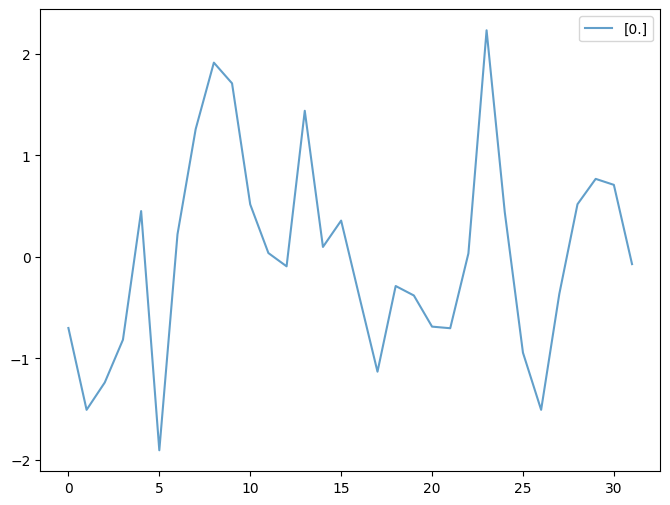

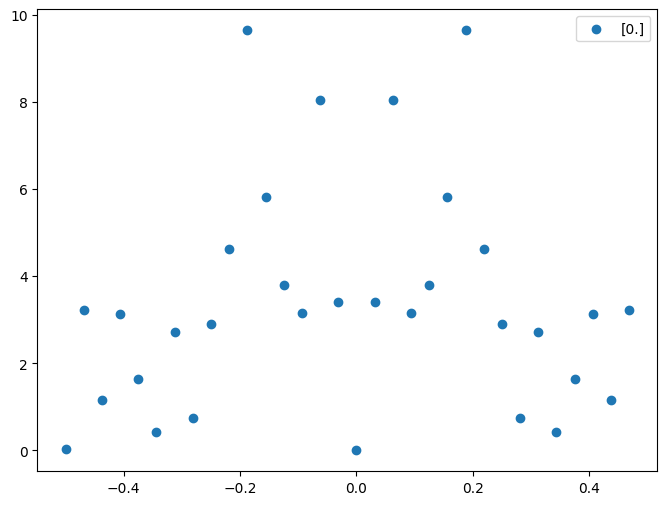

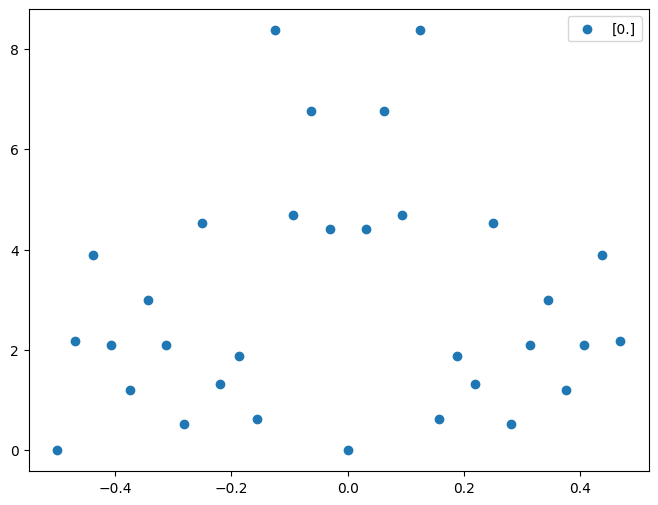

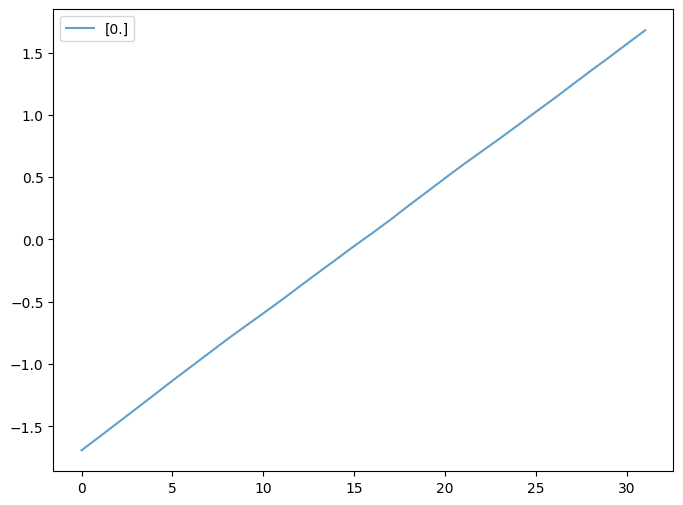

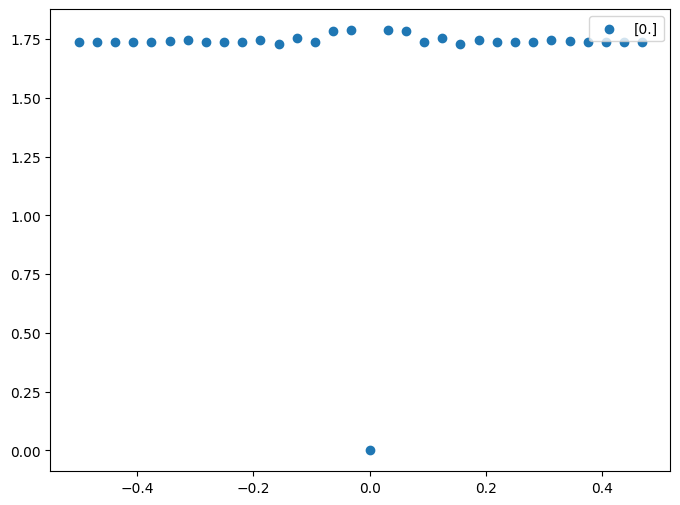

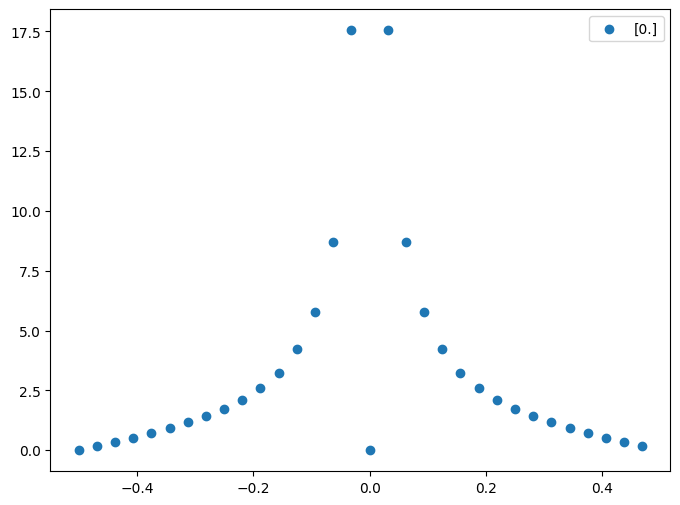

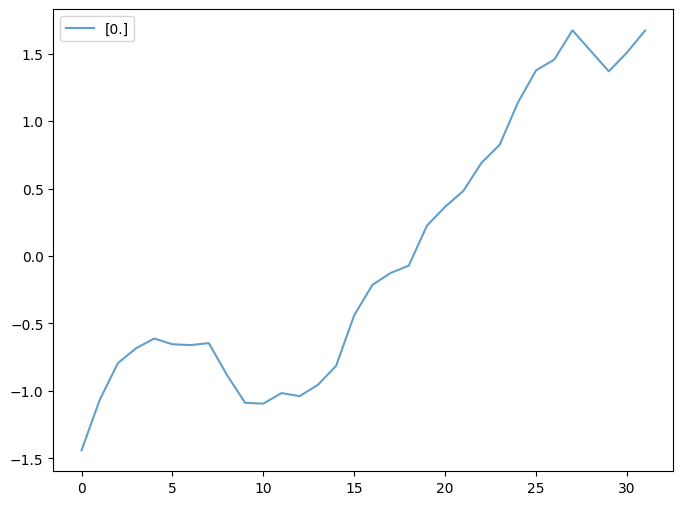

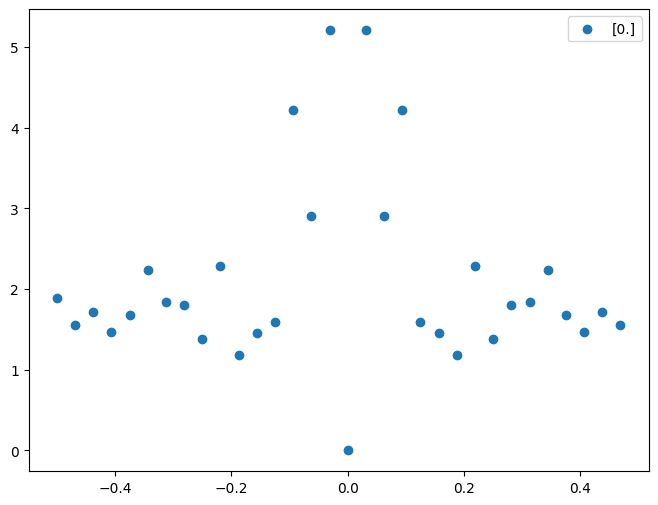

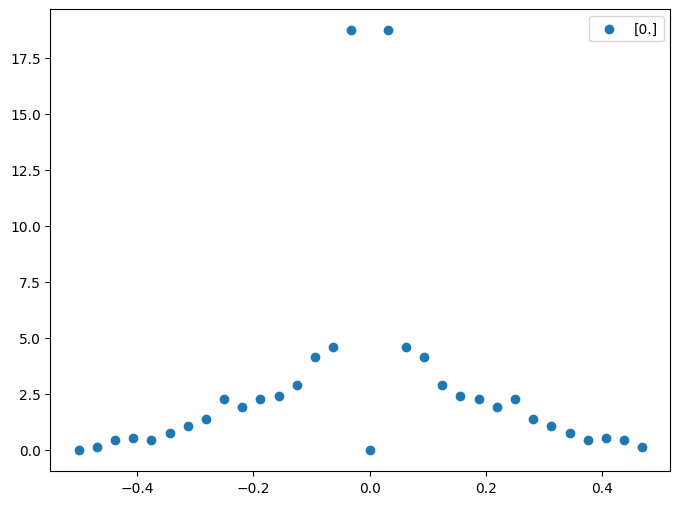

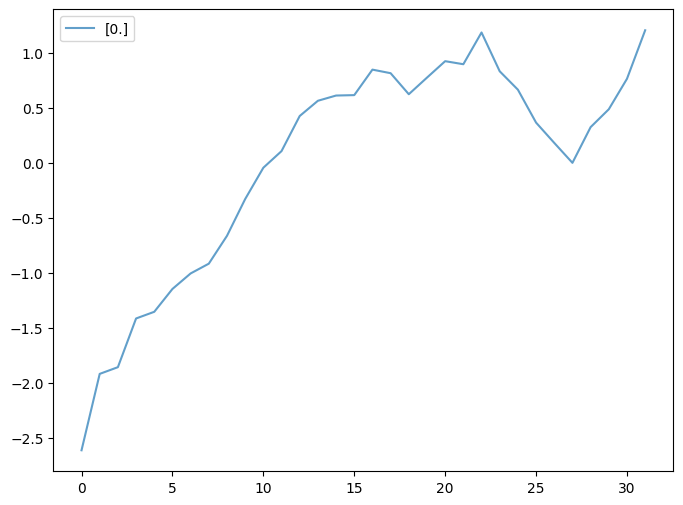

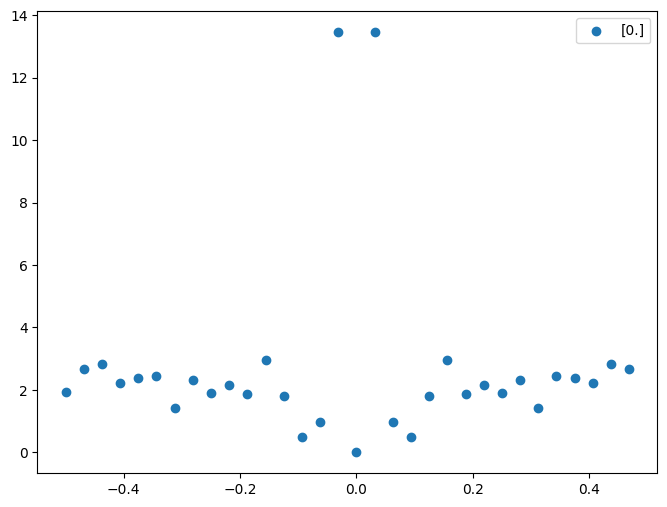

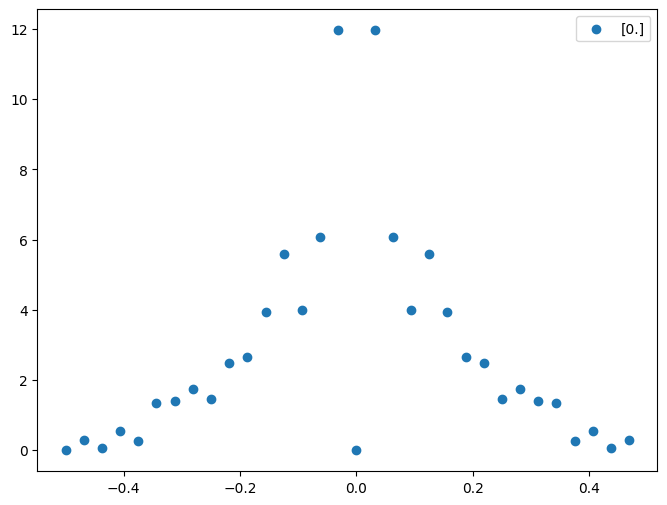

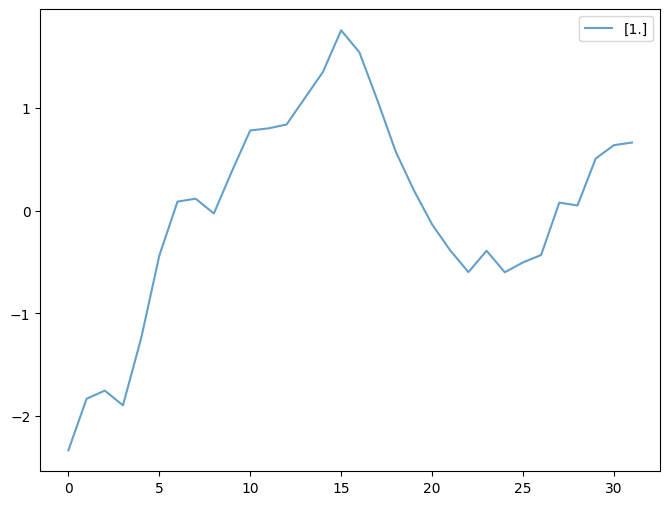

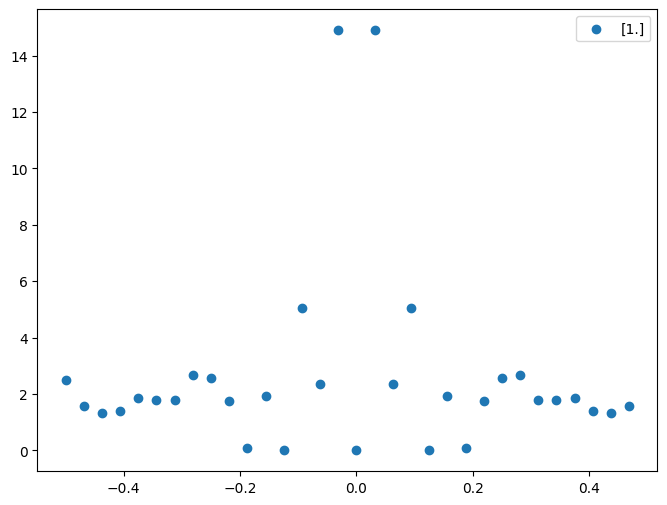

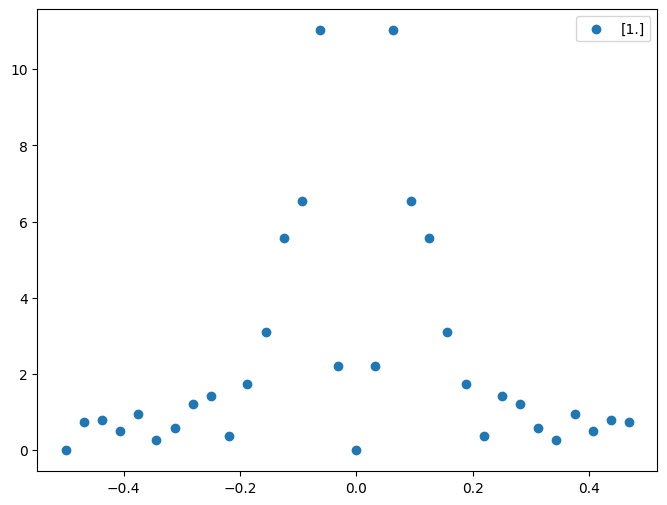

In [11]:
#wide_window = WindowGenerator(
#    input_width=WINDOW_WIDTH, shift=SHIFT)

for example_inputs, example_labels in train_tf.take(5):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')
    plt.figure()
    print(int(example_labels[0]))
    plt.plot(np.arange(len(example_inputs[0, :, 0])), example_inputs[0, :, 0], label=f'{example_labels[0]}', alpha=0.7)
    plt.legend()
    plt.figure()
    plt.scatter(example_inputs[0, :, 1], example_inputs[0, :, 2], label=f'{example_labels[0]}')
    plt.legend()
    plt.figure()
    plt.scatter(example_inputs[0, :, 1], example_inputs[0, :, 3], label=f'{example_labels[0]}')
    plt.legend()

In [15]:
%%time
residual_lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(1024, activation='relu'),
    #tf.keras.layers.LSTM(512),
    #tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'),
    #tf.keras.layers.Conv2D(filters=1024, kernel_size=(2, 2), padding='same', activation='relu'),
    #tf.keras.layers.Conv2D(filters=1024, kernel_size=(2, 2), padding='same', activation='relu'),
    #tf.keras.layers.Conv2D(filters=1024, kernel_size=(2, 2), padding='same', activation='relu'),
    #tf.keras.layers.Conv2D(filters=512, kernel_size=(2, 2), padding='same', activation='relu'),
    #tf.keras.layers.Dense(512),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, return_sequences=True)),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, 'sigmoid'),
])

history = compile_and_fit(residual_lstm, train_tf, val_tf, patience=PATIENCE)

Epoch 1/10000
55/55 - 7s - loss: 0.6870 - binary_accuracy: 0.5705 - val_loss: 0.6807 - val_binary_accuracy: 0.6248 - 7s/epoch - 125ms/step
Epoch 2/10000
55/55 - 4s - loss: 0.6763 - binary_accuracy: 0.6079 - val_loss: 0.6693 - val_binary_accuracy: 0.6192 - 4s/epoch - 81ms/step
Epoch 3/10000
55/55 - 5s - loss: 0.6653 - binary_accuracy: 0.6151 - val_loss: 0.6576 - val_binary_accuracy: 0.6233 - 5s/epoch - 82ms/step
Epoch 4/10000
55/55 - 5s - loss: 0.6573 - binary_accuracy: 0.6171 - val_loss: 0.6511 - val_binary_accuracy: 0.6250 - 5s/epoch - 83ms/step
Epoch 5/10000
55/55 - 5s - loss: 0.6531 - binary_accuracy: 0.6211 - val_loss: 0.6475 - val_binary_accuracy: 0.6263 - 5s/epoch - 82ms/step
Epoch 6/10000
55/55 - 5s - loss: 0.6492 - binary_accuracy: 0.6229 - val_loss: 0.6447 - val_binary_accuracy: 0.6290 - 5s/epoch - 83ms/step
Epoch 7/10000
55/55 - 5s - loss: 0.6468 - binary_accuracy: 0.6259 - val_loss: 0.6424 - val_binary_accuracy: 0.6292 - 5s/epoch - 82ms/step
Epoch 8/10000
55/55 - 4s - loss: 

KeyboardInterrupt: 

In [88]:
%%time
residual_lstm = tf.keras.Sequential([
    #tf.keras.layers.LSTM(512),
    #tf.keras.layers.LSTM(512),
    tf.keras.layers.Conv2D(filters=2048, kernel_size=(2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='valid'),
    tf.keras.layers.Conv2D(filters=1024, kernel_size=(2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1), strides=(1, 1), padding='valid'),
    #tf.keras.layers.Conv2D(filters=1024, kernel_size=(2, 2), padding='same', activation='relu'),
    #tf.keras.layers.Conv2D(filters=512, kernel_size=(2, 2), padding='same'),
    tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu', activity_regularizer=tf.keras.regularizers.L2(0.01)),
    #tf.keras.layers.Dense(256),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, 'sigmoid'),
])

history = compile_and_fit(residual_lstm, wide_window, patience=PATIENCE)

AttributeError: module 'keras.api._v2.keras.losses' has no attribute 'SparseCategorigalCrossentropy'

In [25]:
IPython.display.clear_output()
val_performance = {}
performance = {}
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val, return_dict=True)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, return_dict=True)
print()

10/10 [==============================] - 0s 16ms/step - loss: 1.0609 - binary_accuracy: 0.9225



In [26]:
def make_prediction_set(test_set, window_width):
    pred_set = []
    for i in range(len(test_set)):
        tmp = np.array(test_set[i:i+window_width])
        if len(tmp) == window_width:
            tmp = normalization(tmp.reshape(1, window_width, NB_INPUT_FEATURES))
            pred_set.append(tmp)
    return np.array(pred_set).reshape(len(pred_set), window_width, NB_INPUT_FEATURES)


In [27]:
all_pred = make_prediction_set(df, WINDOW_WIDTH)
all_pred_result = residual_lstm.predict(all_pred)

print(all_pred.shape)
print(all_pred_result.shape, all_pred_result[:10])

3125/3125 [==============================] - 8s 3ms/step
(99991, 10, 2)
(99991, 1) [[2.1113560e-10]
 [9.9998987e-01]
 [6.3761740e-07]
 [6.5630715e-14]
 [1.6473547e-14]
 [6.4829597e-05]
 [1.6769929e-11]
 [9.2350661e-14]
 [2.4099575e-07]
 [5.6520876e-06]]


[  24   25   28   33   73   87   90  176  203  220  285  286  293  304
  327  330  369  433  461  503  536  540  561  566  590  600  618  626
  702  729  747  761  762  772  783  817  830  850  874  896  903  906
  928  937  947  991 1000]
[ 22  23  26  31  71  85  88 174 201 218 283 284 291 302 325 328 367 431
 459 501 534 538 559 564 588 598 616 624 702 705 722 741 772 813 887 908]


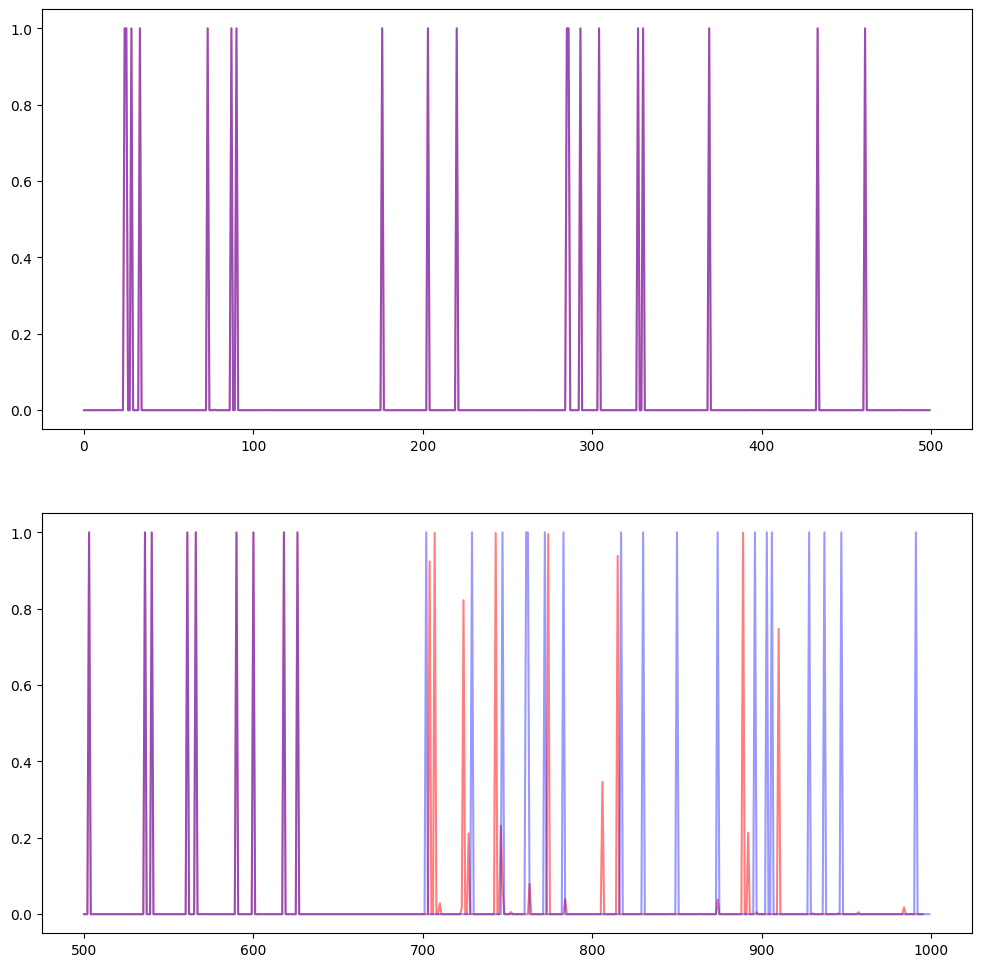

In [39]:
"""
plt.figure()
plt.plot(np.arange(train_result.shape[0]), train_result[:,2], c='red')
plt.plot(np.arange(target_train_df.shape[0]), target_train_df['states'], c='blue')
"""

print(changepoints)
print(np.where(np.round(all_pred_result[:,0]) >=1.0)[0] - int(WINDOW_WIDTH//2))
fig, axs = plt.subplots(T//500, 1, figsize=(12, 12))
for subplot_row in range(T//500):
    axs[subplot_row].plot(
        np.arange(min(1000, len(all_pred_result[:,0][subplot_row*500: subplot_row*500 + 500]))) + subplot_row*500,
        all_pred_result[:,0][subplot_row*500: subplot_row*500 + 500],
        c='red', alpha=0.5)
    axs[subplot_row].plot(
        np.arange(min(500, len(target_df['cps'][subplot_row*500: subplot_row*500 + 500]))) + subplot_row*500,
        target_df['cps'][subplot_row*500: subplot_row*500 + 500],
        c='blue', alpha=0.4)

[     1     30     81 ...  99993  99999 100000]
[   -4    25    76 ... 99775 99778 99866]


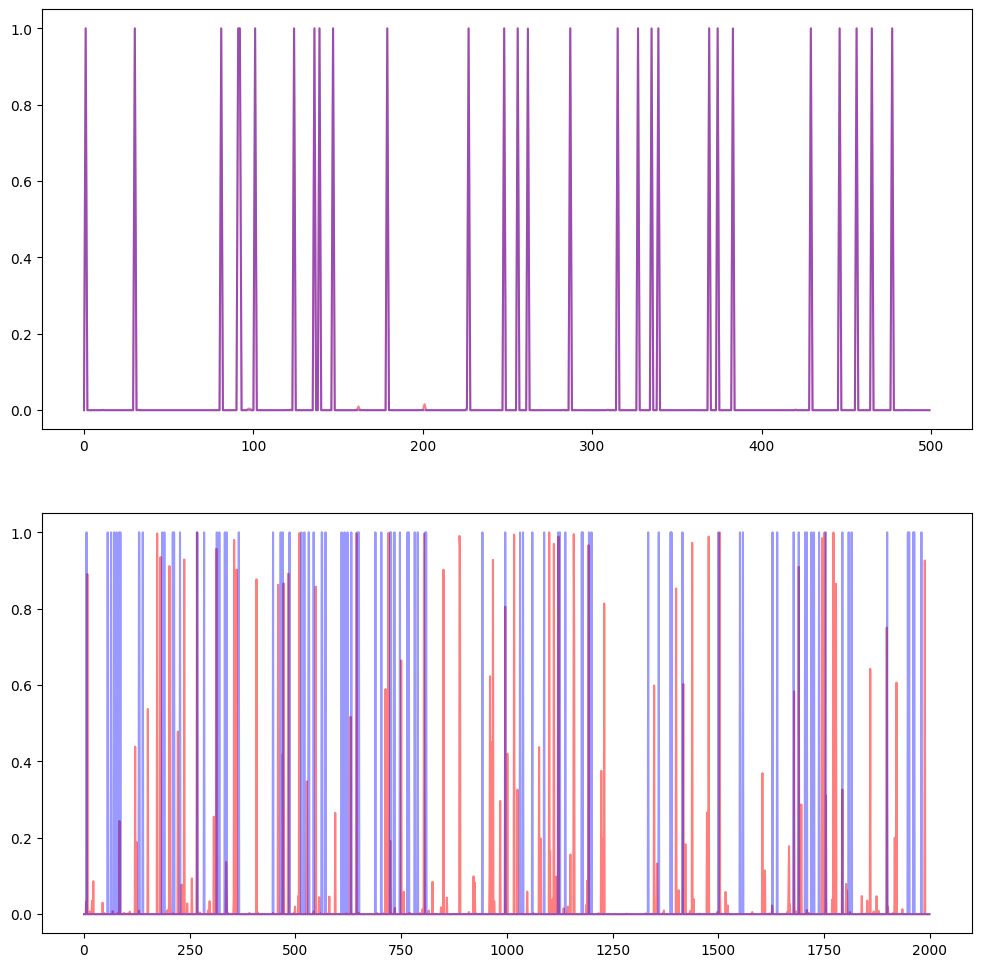

In [32]:
"""
plt.figure()
plt.plot(np.arange(train_result.shape[0]), train_result[:,2], c='red')
plt.plot(np.arange(target_train_df.shape[0]), target_train_df['states'], c='blue')
"""

print(changepoints)
print(np.where(np.round(all_pred_result[:,0]) >=1.0)[0] - int(WINDOW_WIDTH//2))
fig, axs = plt.subplots(2, 1, figsize=(12, 12))
axs[0].plot(
        np.arange(len(all_pred_result[:,0][:500])),
        all_pred_result[:,0][:500],
        c='red', alpha=0.5)
axs[0].plot(
        np.arange(len(all_pred_result[:,0][:500])),
        target_df['cps'][:500],
        c='blue', alpha=0.4)

axs[1].plot(
        np.arange(len(all_pred_result[:,0][int(T*0.7):int(T*0.7) + 2000])),
        all_pred_result[:,0][int(T*0.7):int(T*0.7) + 2000],
        c='red', alpha=0.5)
axs[1].plot(
        np.arange(len(all_pred_result[:,0][int(T*0.7):int(T*0.7) + 2000])),
        target_df['cps'][int(T*0.7):int(T*0.7) + 2000],
        c='blue', alpha=0.4)

In [ ]:
plt.figure()
plt.plot(np.arange(train_result.shape[0]), train_result[:,0], c='red')
plt.plot(np.arange(target_train_df.shape[0]), target_train_df['lb_diff_coefs'], c='blue')

plt.figure()
plt.plot(np.arange(train_result.shape[0]), train_result[:,1], c='red')
plt.plot(np.arange(target_train_df.shape[0]), target_train_df['alphas'], c='blue')

In [25]:
trajectory_object = trajectory_list[12]
trajectory_label = label_list[12]
msd = trajectory_object.get_msd(time_interval=TIME_INTERVAL)
diff_coefs = trajectory_object.get_diffusion_coefs(time_interval=TIME_INTERVAL)
angles = trajectory_object.get_trajectory_angles(time_interval=TIME_INTERVAL)

xs = trajectory_object.get_positions()[:,0]
ys = trajectory_object.get_positions()[:,1]
xs -= xs[0]
ys -= ys[0]

labeled_diff_coefs = trajectory_label[0]
labeled_alphas = trajectory_label[1]
labeled_states = trajectory_label[2]
labeled_cps = trajectory_label[3]

train_df = np.array([xs, ys, msd, diff_coefs, angles]).T
train_df = pd.DataFrame(train_df, columns=['xs', 'ys', 'msd', 'diff_coefs', 'angles'])
target_df = np.array([labeled_diff_coefs, labeled_alphas, labeled_states, labeled_cps]).T
target_df = pd.DataFrame(target_df, columns=['lb_diff_coefs', 'alphas', 'states', 'cps'])

test_ = make_prediction_set(train_df, WINDOW_WIDTH)
test_result = residual_lstm.predict(test_)

6/6 [==============================] - 1s 151ms/step


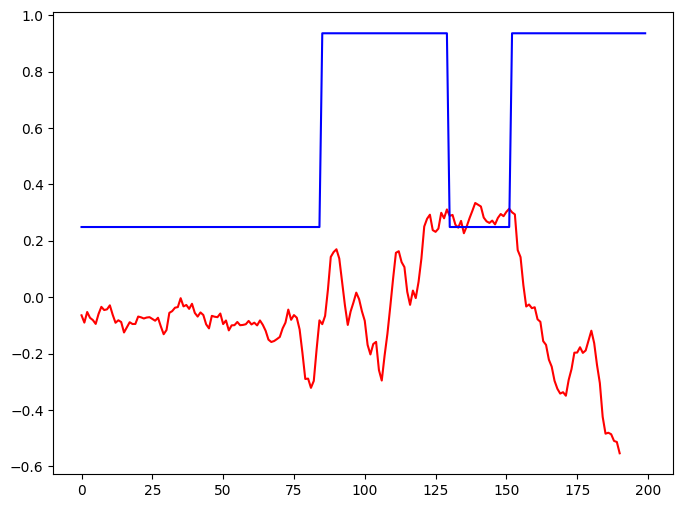

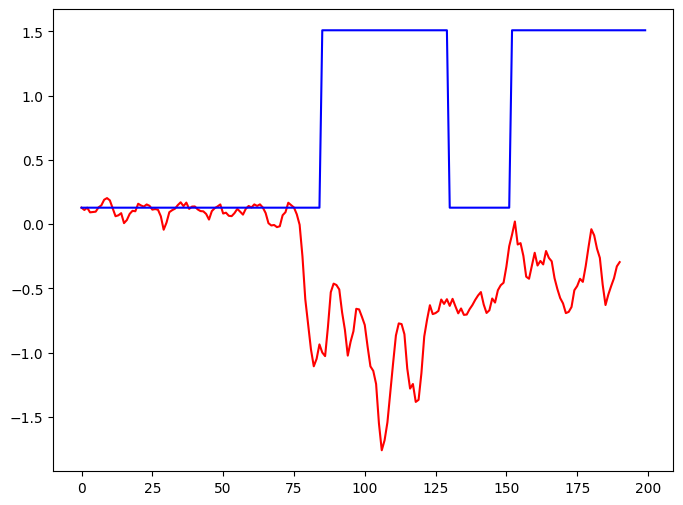

In [26]:
plt.figure()
plt.plot(np.arange(test_result.shape[0]), test_result[:,0], c='red')
plt.plot(np.arange(target_df.shape[0]), target_df['lb_diff_coefs'], c='blue')

plt.figure()
plt.plot(np.arange(test_result.shape[0]), test_result[:,1], c='red')
plt.plot(np.arange(target_df.shape[0]), target_df['alphas'], c='blue')